# Mean single error for each case 

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.quantum_info as qi
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import plot_histogram
from qiskit import execute, transpile, assemble
from qiskit import Aer
from numpy import pi
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer import AerSimulator
print("Import Successfully")

Import Successfully


In [15]:
#FUNZIONI PER CIRCUITO IDEALE
def qft_rotations_ideal(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations_ideal(circuit, n)

def swap_registers_ideal(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_ideal(circuit, n):
    qft_rotations_ideal(circuit, n)
    swap_registers_ideal(circuit, n)
    return circuit

#FUNZIONI PER CIRCUITO NOISY
def qft_rotations(circuit, n, case, position):
    if n == 0:
        return circuit
    n -= 1

    if case == 4:
        errori(circuit, position)
    
    circuit.h(n)   

    if case == 5:
        errori(circuit, position)
    
    
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n, case, position)

def swap_registers(circuit, n):

    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

def qft(circuit, n, case, position):
    if case == 1:
        errori(circuit, position) 

    qft_rotations(circuit, n, case, position)

    if case == 2:
        errori(circuit, position)

    swap_registers(circuit, n)    

    if case == 3:
        errori(circuit, position)
        
    return circuit

def errori(circuit, position):
    epsilon = 1                          
    extracted = random.uniform(0, 1)
    if (extracted < epsilon):    
        circuit.x(position)                            #<-----------------change the type of error here!

qubits = 3       

label = [0]*(2**qubits)
register = QuantumRegister(qubits)
risultato = []
distanze = []
data = []

for stato in range(2**qubits):

    label[stato] = 1
    state = Statevector(label)
    
    # circuito ideale
    qc_ideal = QuantumCircuit(register) 
    qc_ideal.initialize(state.data, register)
    qft_ideal(qc_ideal,qubits)
    qc_ideal.save_density_matrix()
    #qc_ideal.measure_all()

    #simulazione ideale
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc_ideal, aer_sim)
    qobj = assemble(t_qc)                                
    results = aer_sim.run(qobj, shots = 1).result()

    density_matrix_ideal = 0
    density_matrix_ideal = results.data().get('density_matrix')
    density_matrix_ideal = np.asarray(density_matrix_ideal)
    

    for case in range(1, 5):
        for position in range(qubits):
            runs = 1
            for i in range(runs):         

                #circuito noisy
                qc_noisy = QuantumCircuit(register)
                qc_noisy.initialize(state, register)
                qft(qc_noisy,qubits, case, position)
                qc_noisy.save_density_matrix()

                #simulazione noisy
                aer_sim = Aer.get_backend('aer_simulator')
                t_qc = transpile(qc_noisy, aer_sim)
                qobj = assemble(t_qc)                                
                results = aer_sim.run(qobj, shots = 1).result()

                #estrazione matrice densità

                density_matrix = results.data().get('density_matrix')
                density_matrix = np.asarray(density_matrix)

                #calcolo della distanza
                diff = density_matrix - density_matrix_ideal
                mult = np.matmul(np.transpose(diff), diff)
                rad = np.sqrt(mult)
                distanza = rad.trace()/2
                risultato.append(distanza)

                qc_noisy = 0 
                distanza = 0
                diff = 0
                density_matrix = 0
                results = 0
    print(label , 'Stabilità = ', sum(risultato)/(qubits**2) )
    data.append(sum(risultato)/(qubits**2))
    label = [0]*(2**qubits)
    risultato = [0]
            

[1, 0, 0, 0, 0, 0, 0, 0] Stabilità =  (1.0648604918411801+8.1513846712465095e-19j)
[0, 1, 0, 0, 0, 0, 0, 0] Stabilità =  (0.3001557962308817+1.6864733928912966e-10j)
[0, 0, 1, 0, 0, 0, 0, 0] Stabilità =  (0.3903219650734042+0.44444444391096427j)
[0, 0, 0, 1, 0, 0, 0, 0] Stabilità =  (0.14302095276721263-5.537039365271342e-10j)
[0, 0, 0, 0, 1, 0, 0, 0] Stabilità =  (1.0648604918411801+7.586841623879728e-19j)
[0, 0, 0, 0, 0, 1, 0, 0] Stabilità =  (0.30015579576919743+2.0163490468564466e-09j)
[0, 0, 0, 0, 0, 0, 1, 0] Stabilità =  (0.39032196541809466+0.44444444426632185j)
[0, 0, 0, 0, 0, 0, 0, 1] Stabilità =  (0.14302095738450993+1.5153499533859428e-09j)


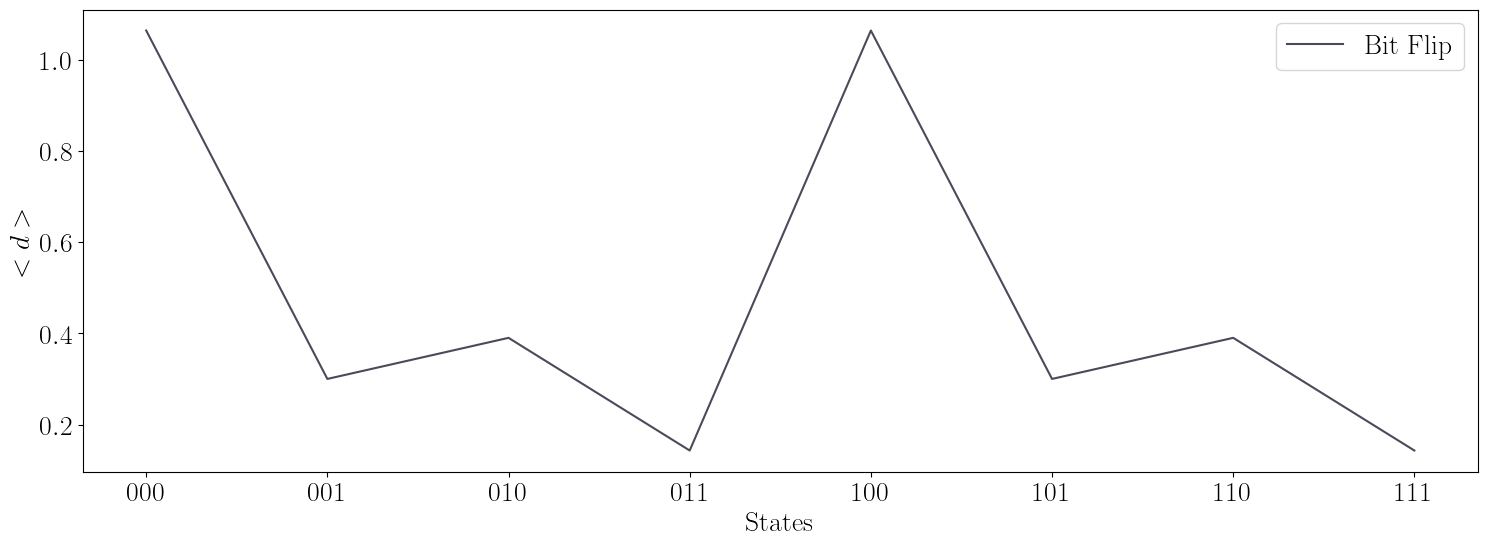

In [16]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 6))
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)
n = qubits
row = []
xs = []
for i in range(2**n):
    tmp = '{0:0b}'.format(i)
    tmp_list = [int(x) for x in tmp]
    while len(tmp_list) != n:
        tmp_list.insert(0, 0)
    tmp_final = ''.join(map(str, tmp_list))
    row.append(tmp_final)
    xs.append(i)

row_labels = row
plt.xticks(xs, row_labels)

plt.xlabel('States')
plt.ylabel(r"$<d>$")
plt.plot(data, color = '#4C495A', label = 'Bit Flip')
plt.legend()
#plt.savefig('QFT_mean_errorsBIT.pdf', format = 'pdf')

